<a href="https://colab.research.google.com/github/ronald-hk-chung/ssnotebook/blob/main/computer_vision/alexnet_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building AlexNet from Scratch

**Mission Statement:**

1. Build AlexNet from Scratch using nn.Module
2. Training our model using CIFAR10 dataset

## Notebook Preperation

In [1]:
!pip install -q git+https://github.com/ronald-hk-chung/sstorch.git

from sstorch.learner import SSTLearner
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchinfo

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


## Introduction to AlexNet

The architecture was developed by the SuperVision Team, composed of Alex Krizhevsky, Iiya Sutskever, and Geoffrey Hinton from the University of Toronto. AlexNet managed to achieve a top-5 error of 15.3% in the 2012 edition of ImageNet Large Scale Visual Recognition Challenge (ILSVRC) and represented a milestone for image classification.

Details of the architecture can be found from the original paper [ImageNet Classification with Deep Convolutional Neural Networks](https://proceedings.neurips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

Belows is a detail layout of the architecture:

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/alexnet_architecture_simple2.png?raw=true">

<br/>

**Key Features**

AlexNet contains 8 layers: 5 convolutional layers, some of them followed by max-pooling layers, and 3 fully connected linear layers. In the original paper, the network (except the last layer) is split into 2 copies, each run on one GPU.

Note that Input size for PyTorch implimentation is 224x224x3. Note that original paper mentioned it shoudl be 227x227x3 and that is due to padding at the first convolutional layer. We will follow PyTorch implimentation with first conv layer using padding of 2

The entire structure can be written as:

$$
(CNN \rightarrow RN \rightarrow MP)^2 \rightarrow (CNN^3 \rightarrow MP) \rightarrow (FC \rightarrow DO)^2 \rightarrow Linear \rightarrow softmax
$$

where:

* $CNN$ = convolutional layer (with ReLU activation)
* $RN$ = local response normalization
* $MP$ = maxpooling
* $FC$ = fully connected layer (with ReLU activation)
* $Linear$ = fully connected layer (without activation)
* $DO$ = dropout

<br/>

Note that torchvision implimentation of Alexnet is based on the [Alexnet One weird trick](https://arxiv.org/abs/1404.5997) paper and the number of parameters are reduced.

We will try to impliment from its original paper with a added AvgPool layer to give freedom to use images of different sizes as inputs



In [2]:
import torch
import torch.nn as nn
from collections import OrderedDict

class AlexNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000):
        super().__init__()

        # 5 conv block for features
        self.conv_block1 = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=in_channels, out_channels=96, kernel_size=(11, 11), stride=4, padding=2)),
            ('relu1', nn.ReLU()),
            ('lrn1', nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2)),
            ('maxpool1', nn.MaxPool2d(kernel_size=(3, 3), stride=2))
        ]))

        self.conv_block2 = nn.Sequential(OrderedDict([
            ('conv2', nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5, 5), padding=2)),
            ('relu2', nn.ReLU()),
            ('lrn2', nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2)),
            ('maxpool2', nn.MaxPool2d(kernel_size=(3, 3), stride=2))
        ]))

        self.conv_block3 = nn.Sequential(OrderedDict([
            ('conv3', nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3, 3), padding=1)),
            ('relu3', nn.ReLU())
        ]))

        self.conv_block4 = nn.Sequential(OrderedDict([
            ('conv4', nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), padding=1)),
            ('relu4', nn.ReLU())
        ]))

        self.conv_block5 = nn.Sequential(OrderedDict([
            ('conv5', nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1)),
            ('relu5', nn.ReLU()),
            ('maxpool5', nn.MaxPool2d(kernel_size=(3, 3), stride=2))
        ]))

        self.features = nn.Sequential(OrderedDict([
            ('conv_block1', self.conv_block1),
            ('conv_block2', self.conv_block2),
            ('conv_block3', self.conv_block3),
            ('conv_block4', self.conv_block4),
            ('conv_block5', self.conv_block5)
        ]))

        # Avg pool layer before classifier
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(6, 6))

        # Define fc for classifiers
        self.fc1 = nn.Sequential(OrderedDict([
            ('flatten', nn.Flatten()),
            ('linear1', nn.Linear(in_features=9216, out_features=4096)),
            ('dropout1', nn.Dropout(p=0.5)),
            ('relu_fc1', nn.ReLU())
        ]))

        self.fc2 = nn.Sequential(OrderedDict([
            ('linear2', nn.Linear(in_features=4096, out_features=4096)),
            ('dropout2', nn.Dropout(p=0.5)),
            ('relu_fc2', nn.ReLU())
        ]))

        self.fc3 = nn.Linear(in_features=4096, out_features=num_classes)
        self.classifier = nn.Sequential(
            self.fc1,
            self.fc2,
            self.fc3
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

In [3]:
# define model
model = AlexNet(in_channels=3, num_classes=10)

torchinfo.summary(model=model,
                  input_size=(1, 3, 224, 224),
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [1, 3, 224, 224]     [1, 10]              --                   True
├─Sequential (features)                  [1, 3, 224, 224]     [1, 256, 6, 6]       --                   True
│    └─Sequential (conv_block1)          [1, 3, 224, 224]     [1, 96, 27, 27]      --                   True
│    │    └─Conv2d (conv1)               [1, 3, 224, 224]     [1, 96, 55, 55]      34,944               True
│    │    └─ReLU (relu1)                 [1, 96, 55, 55]      [1, 96, 55, 55]      --                   --
│    │    └─LocalResponseNorm (lrn1)     [1, 96, 55, 55]      [1, 96, 55, 55]      --                   --
│    │    └─MaxPool2d (maxpool1)         [1, 96, 55, 55]      [1, 96, 27, 27]      --                   --
│    └─Sequential (conv_block2)          [1, 96, 27, 27]      [1, 256, 13, 13]     --                   True
│    │    └─Conv2d (

## Properties of AlexNet

**Faster Learning with ReLU**

AlexNet uses `ReLU` as activation function which is more common in modern neural networks. Conventional `tanh` and `sigmoid` are saturating functions which not only limit the learning of the model at the boundaries but are also computationally expensive. The backpropagation during training in `ReLU` is computationally inexpensive since it uses a simple max function between the input and zero instead of exponential calculation, and the derivative is either 0 or 1. The ReLU function does not saturate at extreme values and prevents zero slopes, hence preventing vanishing gradient problem as seen in sigmoidal and tach funcitons.

<br/>

**Local Response Normalization (LRN)**

Loacal Response Normalization (LRN) was first introduced in AlexNet architecture where the activation function used was `ReLU`. Since `ReLU` activation funcions are not constrained within a bounded range( such as [-1, 1] for `tach`), rather they can grow as high as the training allows it. To limit he unbounded activation from increasing the output layer values, normalization will need to be applied. LRN also encourage lateral inhibition which is a concept in Neurobiology that refers to the capcity of a neuron to reuce the activity of its neighbors.

LRN is a non-trainable layer that square-normalizes the pixel values in a feature map within a local neighborhood. There are two types of LRN based ont the neigborhood defined:

In the AlexNet paper, the neighborhood defined is across the channel. For each (x, y) position, the normaliation is carreid out in the depth dimension and is given by the following formula:

$$
b_{x, y}^i=a_{x, y}^i /\left(k+\alpha \sum_{j=\max (0, i-n / 2)}^{\min (N-1, i+n / 2)}\left(a_{x, y}^j\right)^2\right)^\beta
$$

where:
* $i$ indicates teh output of filter i
* $a(x,y)$ are the pixel values at $(x,y)$ position before normalization after ReLU activation
* $b(x,y)$ are the pixel values at $(x,y)$ position after normalization
* $N$ is the total number of channels for normalization given by parameter `size`
* $k$ is used to avoid any singularities (division by zero)
* $\alpha$ is used as a normalization constant
* $\beta$ is a contrasting contant
* $n$ is used to define the neighborhood length, i.e. how many consecutive pixel values need to be considered while carrying out the normalization

<br/>

The sum operator range inside the normalization range from $\frac{n}{2}$ to its left and $\frac{n}{2}$ to its right which is its neighbours across channels, while taking care of the bounds i.e. $0$ and $N-1$

$\alpha$, the normalization constant, controls the ammount to diminish its value in comparison to the numerator, in order to preserve the value of the activation in the numerator. For high $\alpha$, the activation in the numerator will be diminished, thus leading to a vanishing gradient. For very low $\alpha$, it will lead to exploding gradients

$\beta$, the contrasting constant, controls the magnitude/effect of this local response on the activation in question. A high $\beta$ will penalize the activation w.r.t to its neibours more while a lower $\beta$ will not affect the activation in question much w.r.t. to its neigbours

Local Response Normalization helps to bring out those activations that are performing much better w.r.t. its neighbours. This helps to increase the efficiency of the network as some neurons will be acting as the core of the network which leads to faster computation.

It will also diminish reducdant features, as it normalizes the adjacent neurons that are having high values which then will suppress the redundant, continuous features, thus helping the adjacent neurons to learn better to differentiate themselves from others in their neighbourhood - *competitive normalization*

Note that Local Response Normalization is not common anymore as Batch Normalization is preferred that will get rid of internal covariate shift. Batch Normalization is trainable and has a regularization effect as compared to Local Response Normalization which is not tranable and has no regularization effect

<br/>

**Overlapping Pooling**

AlexNet used pooling windows of size 3x3 and a stride of 2 between teh adjacent windows which results in overlap pooling. Overlapping pooling conserve the spatial information where density of low values is high. This leads to lower senitivity to the dominant features in focus and less prone for overfitting and poor generalization.

<br/>

**Data Augmentation**

Data Augmentation is a powerful technique in Machine Learning. It involves taking input data an dmodifying it by applying functions. We then use both the synthetically generated data and teh original data as input for our models which allow our models to generalize to noisy input much better, and help generalize unseen distribution.

AlexNet uses image translation and horizontal reflection for Data Augmentation. They also altered the intensities of the RGB channels in training examples.

In the below exercise, we will use TrivalAugment which takes an image x and a set of augmentations A as input. It then simply samples an augmentation from A uniformly at random and appplies this augmentation to the given image x with a strenght m, sampled uniformly at random from the set of possible strenghts [0-31], and retusn teh augmented image.

## Introduction to CIFAR10 Dataset

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) is one of the most popular image datasets in computer vision. CIFAR-10 consists of 60,0000 32x32 color images in 10 classes, splitting into 50,000 images for training and 10,000 images for validation.

Belows shows the classes in teh dataset:

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/cifar10.png?raw=true">

We can first download CIFAR-10 dataset from torchvision

In [4]:
import torchvision
from torchvision.datasets import CIFAR10

train_ds = CIFAR10(root='data',
                   train=True,
                   download=True)

valid_ds = CIFAR10(root='data',
                   train=False,
                   download=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 56697562.38it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


Note that we haven't applied the necessary transforms for our train_ds.

In order to use our the dataset with AlexNet, we will have to resize the image to (224, 224) by `Resize()` and normalise the images with each channel mean and standard deviations by `Normalise()`

In [5]:
# To get the mean and standard deviations of cifar10
data_shape = train_ds.data.shape
data_mean = train_ds.data.mean(axis=(0, 1, 2))/255
data_std = train_ds.data.std(axis=(0, 1, 2))/255

print(f'Shape of Data: {data_shape}')
print(f'Mean of Data: {data_mean}')
print(f'Std of Data: {data_std}')

Shape of Data: (50000, 32, 32, 3)
Mean of Data: [0.49139968 0.48215841 0.44653091]
Std of Data: [0.24703223 0.24348513 0.26158784]


In [6]:
import torchvision.transforms as T
from torch.utils.data import DataLoader

# Define transforms from PIL to Tensors
tfms = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize(mean=data_mean,
                std=data_std)
])

# Define transforms from PIL to Tensors with Data Augmentation
tfms_augmented = T.Compose([
    T.Resize(size=(224, 224)),
    T.TrivialAugmentWide(num_magnitude_bins=10),
    T.ToTensor(),
    T.Normalize(mean=data_mean,
                std=data_std)
])

# Define reverse transforms from Tensors to PIL (for visualisation)
rtfms = T.Compose([
    T.Normalize(mean=[0.0] * 3,
                std=list(map(lambda x: 1 / x, data_std))),
    T.Normalize(mean=list(map(lambda x: -x, data_mean)),
                std=[1.0] * 3),
    T.ToPILImage()
])

# Apply transforms to dataset
train_ds = CIFAR10(root='data',
                   train=True,
                   transform=tfms_augmented,
                   download=True)

valid_ds = CIFAR10(root='data',
                   train=False,
                   transform=tfms,
                   download=True)

# Define classes and classes_to_idx
classes = train_ds.classes
class_to_idx = train_ds.class_to_idx

# Create DataLoader for train/valid dataset
train_dl = DataLoader(dataset=train_ds,
                      batch_size=128,
                      shuffle=True)

valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=128,
                      shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


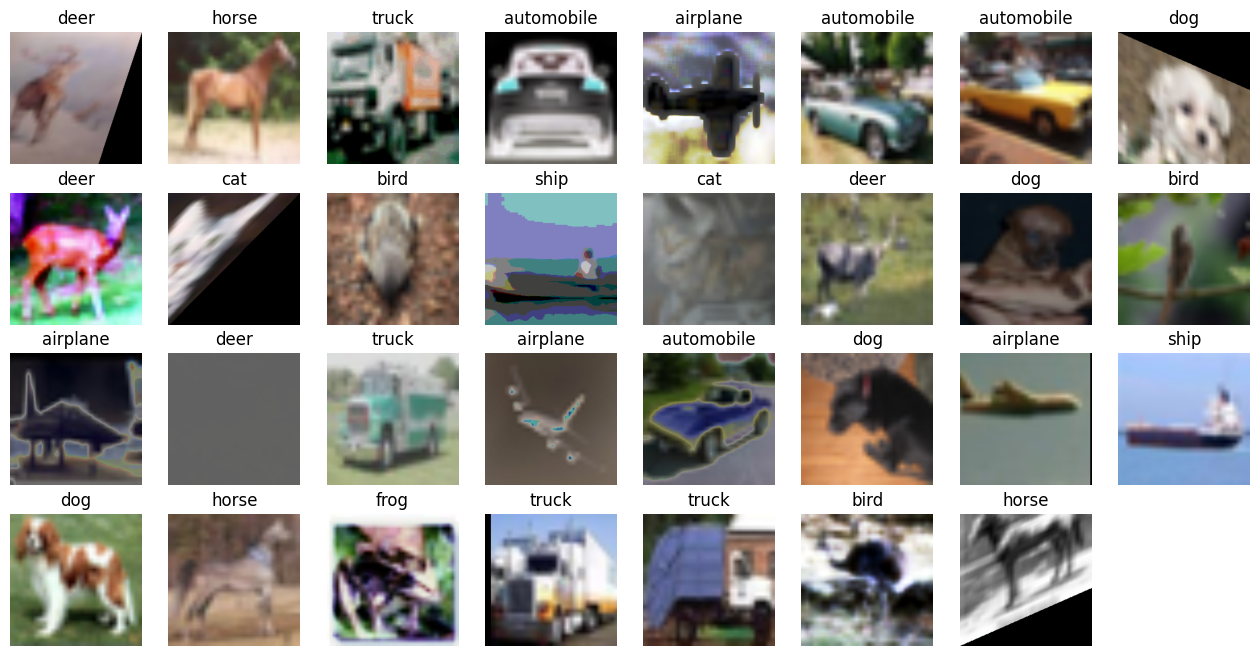

In [7]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_dl))

# Show one batch of data
fig = plt.figure(figsize=(16, 8))
rows, cols = 4, 8
for i, image in enumerate(images[:31]):
    plt.subplot(rows, cols, i+1)
    plt.imshow(rtfms(image))
    plt.title(classes[labels[i]])
    plt.axis(False)

## Human-Level Accuracy vs. The State-of-The-Art Accuracy on CIFAR-10

The error rate of a human on CIFAR-10 is estimated to be around [6%](https://medium.com/kaggle-blog/convolutional-nets-and-cifar-10-an-interview-with-yann-lecun-2ffe8f9ee3d6).

According to [paperswithcode.com](https://paperswithcode.com/sota/image-classification-on-cifar-10), the best model can reach 99% accuracy on CIFAR-10 as shown below:

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/cifar10_leaderboard.png?raw=true">

## Setting up Learner class from SSTLearner

In [8]:
from sstorch.learner import SSTLearner
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# define model
model = AlexNet(in_channels=3, num_classes=10)

# define loss_fn
loss_fn = nn.CrossEntropyLoss()

# define metric_fn as accuracy
def metric_fn(y_logits, y):
    # Make prediction using argmax and turn into numpy array
    y_preds = torch.argmax(y_logits, dim=-1).detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    # Calculate scores from using sklearn.metrics
    accuracy = accuracy_score(y, y_preds)
    return {'accuracy': accuracy}

# define optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=1e-4)


learner = SSTLearner(model=model,
                     loss_fn=loss_fn,
                     metric_fn=metric_fn,
                     optimizer=optimizer,
                     train_dataloader=train_dl,
                     valid_dataloader=valid_dl)

# Find the optimal learning rate

  0%|          | 0/100 [00:00<?, ?it/s]

Max Gradient: 1.23E-04 | Lowest Loss: 9.06E-04


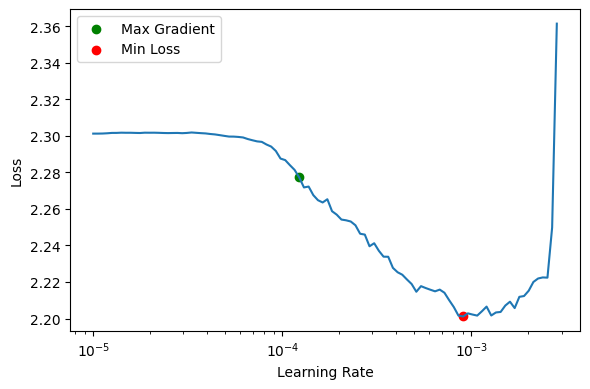

In [9]:
learner.lr_range_test(end_lr=3e-3, start_lr=1e-5)

In [16]:
learner.train(5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 26 | LR: 1.0E-04 | train_loss: 0.351 | valid_loss: 0.479 
train_metric: {'accuracy': 0.884}
valid_metric: {'accuracy': 0.862}
----------------------------------------------------------------------------------------------------
Epoch: 27 | LR: 1.0E-04 | train_loss: 0.343 | valid_loss: 0.482 
train_metric: {'accuracy': 0.886}
valid_metric: {'accuracy': 0.858}
----------------------------------------------------------------------------------------------------
Epoch: 28 | LR: 1.0E-04 | train_loss: 0.332 | valid_loss: 0.469 
train_metric: {'accuracy': 0.888}
valid_metric: {'accuracy': 0.863}
----------------------------------------------------------------------------------------------------
Epoch: 29 | LR: 1.0E-04 | train_loss: 0.321 | valid_loss: 0.466 
train_metric: {'accuracy': 0.892}
valid_metric: {'accuracy': 0.863}
----------------------------------------------------------------------------------------------------
Epoch: 30 | LR: 1.0E-04 | train_loss: 0.311 | valid_loss: 0.508 

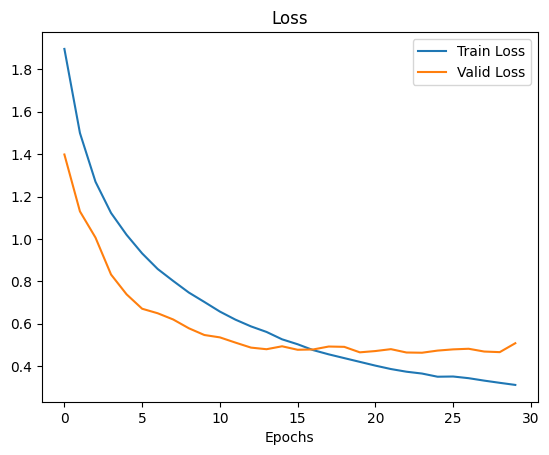

In [17]:
learner.plot_loss_curve()

Our model manage to achieve ~86% valid accuracy which is a reasonable result for AlexNet

## Notebook Summary:

1. Impliment Alexnet wtih original setup including LRN layer
2. Train our model with Cifar-10 with TrivalAugmentation
3. Manage to get reasonable result which is in line from paperswithcode leaderboard for earlier CNN model